## Goal: Latent representations of news outlets 

In [2]:
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise.reader import Reader
from surprise import Dataset
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"

#we are bringing in the data with demographic information and cluster ids 
#hence, merged
#MVP path merged = pd.read_csv("/shared/3/prohttps://eribean.github.io/girth/docs/quickstart/quickstart/jects/benlitterer/localNews/data/interim/SingleNE_85_clustered.tsv", sep="\t")
merged = pd.read_csv(IN_PATH, sep="\t")
merged = merged.dropna(subset=["clustNum"])

<ipython-input-3-0d2084b2e61c>:6: DtypeWarning: Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  merged = pd.read_csv(IN_PATH, sep="\t")


In [4]:
merged["clustNum"] = merged["clustNum"].astype(int)

In [6]:
outletGroups = merged[["source", "clustNum"]].groupby("source").agg(set)
#outletGroups["len"] = outletGroups["clustNum"].apply(len)
#outletGroups = outletGroups.sort_values("len").head(400)
outletDict = outletGroups.to_dict(orient="index")

In [7]:
MAX_CLUSTNUM = max(merged["clustNum"])
OUTLET_COUNT = len(outletGroups)

In [8]:
#choiceMat = np.zeros((OUTLET_COUNT, MAX_CLUSTNUM), dtype=int)

In [9]:
from tqdm import tqdm

In [10]:
#TODO: check indexing

#change the appropriate indices to have zeros 
#this is the list telling us which index is which outlet in our matrix 
sortedOutlets = sorted(list(outletGroups.index))

#get the data in long format
#since we are zero indexed we have one more story than 
#the max story index 
coverageMat = np.zeros((len(sortedOutlets), MAX_CLUSTNUM+1))

for i, outlet in tqdm(enumerate(sortedOutlets)): 
    
    #the indices corresponding to stories that are covered for this outlet 
    artIndices = outletDict[outlet]["clustNum"]
    
    #add the outlet ID and story ID
    #if we have a max clust num of 5, that means we have 6 clusters (0 indexed)
    for artIndex in artIndices: 
        coverageMat[i, artIndex] = 1

787it [00:00, 1081.69it/s]


In [11]:
coverageMat.shape

(787, 209414)

In [19]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.manifold import TSNE

In [20]:
model = NMF(n_components=50)

W = model.fit_transform(coverageMat)
H = model.components_

/opt/anaconda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [21]:
#for each story (row), we get the loadings on each latent factor 
H.T.shape

(209414, 50)

In [22]:
#for each outlet (row), we get the loadings on each latent factor 
W.shape

(787, 50)

In [23]:
model = TruncatedSVD(n_components=200)

W = model.fit_transform(coverageMat)
H = model.components_

In [24]:
H.shape

(200, 209414)

In [25]:
sum(model.explained_variance_ratio_)

0.87422650546785

In [26]:
model.explained_variance_ratio_[:5]

array([0.06165617, 0.03434623, 0.0288245 , 0.02750571, 0.01918606])

In [27]:
#now, let's just project onto the first couple factors? 

In [12]:
demographicsDf = merged[['source', 'total_population', 'national',
       'white_pct', 'black_pct', 'hispanic_pct', 'nonwhite_pct',
       'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'fips', 'state']].drop_duplicates("source")

In [13]:
poliDf = pd.read_csv("/shared/3/projects/benlitterer/localNews/NELAdata/CSVs/politics.csv")
demographicsDf = pd.merge(poliDf, demographicsDf, on="fips", how="outer")

In [14]:
projDf = pd.DataFrame(W[:,:6], columns=["f1", "f2", "f3", "f4", "f5", "f6"])
projDf["source"] = sortedOutlets

projDf = pd.merge(projDf, demographicsDf, on="source", how="left")
storyCounts = merged[["source", "clustNum"]].groupby("source").agg(len).rename(columns={"clustNum":"articleCount"})
projDf = pd.merge(projDf, storyCounts, on="source", how="left")

NameError: name 'W' is not defined

In [15]:
#merge ownership into our projection dataframe 
ownershipDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/ownership/infoboxOwnership.csv").rename(columns={"ogName":"source"})
projDf = pd.merge(projDf, ownershipDf[["source", "search result", "cleanedOwner"]], on="source", how="left")

NameError: name 'projDf' is not defined

In [298]:
import matplotlib.pyplot as plt

In [299]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})

Text(0.5, 1.0, 'outlets projected along first two SVD factors')

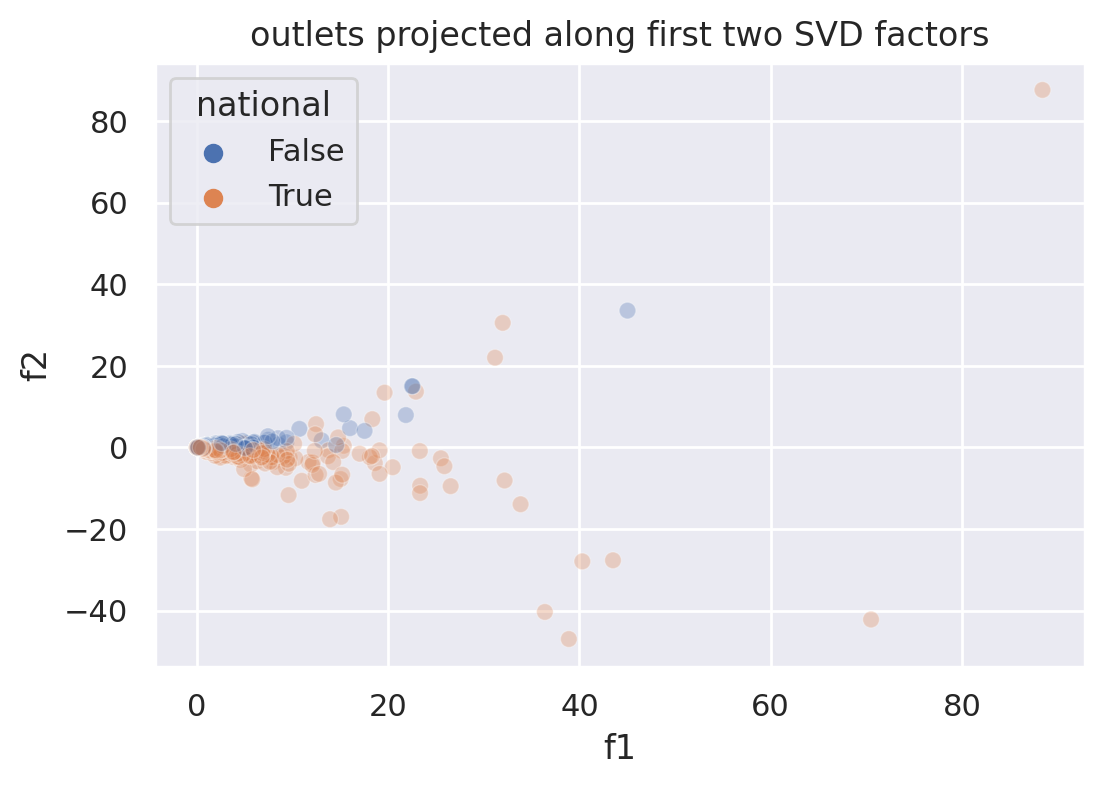

In [300]:
#d2 could mean something like local / national 
sns.scatterplot(x="f1", y="f2", hue="national", data=projDf, alpha=.3)
#plt.ylim(-20, 20)
plt.title("outlets projected along first two SVD factors")

In [301]:
INTER_PATH = "/home/blitt/projects/localNews/notebooks/similarityAnalysis/plotly/"

In [302]:
import plotly.express as px
import plotly.offline as ofl
plotly.offline.init_notebook_mode(connected=True)
fig = px.scatter(projDf, x="f1", y="f2", hover_data="source")
fig.write_html(INTER_PATH + "f1_f2.html")

Text(0.5, 1.0, 'outlets projected along third and fourth SVD factors')

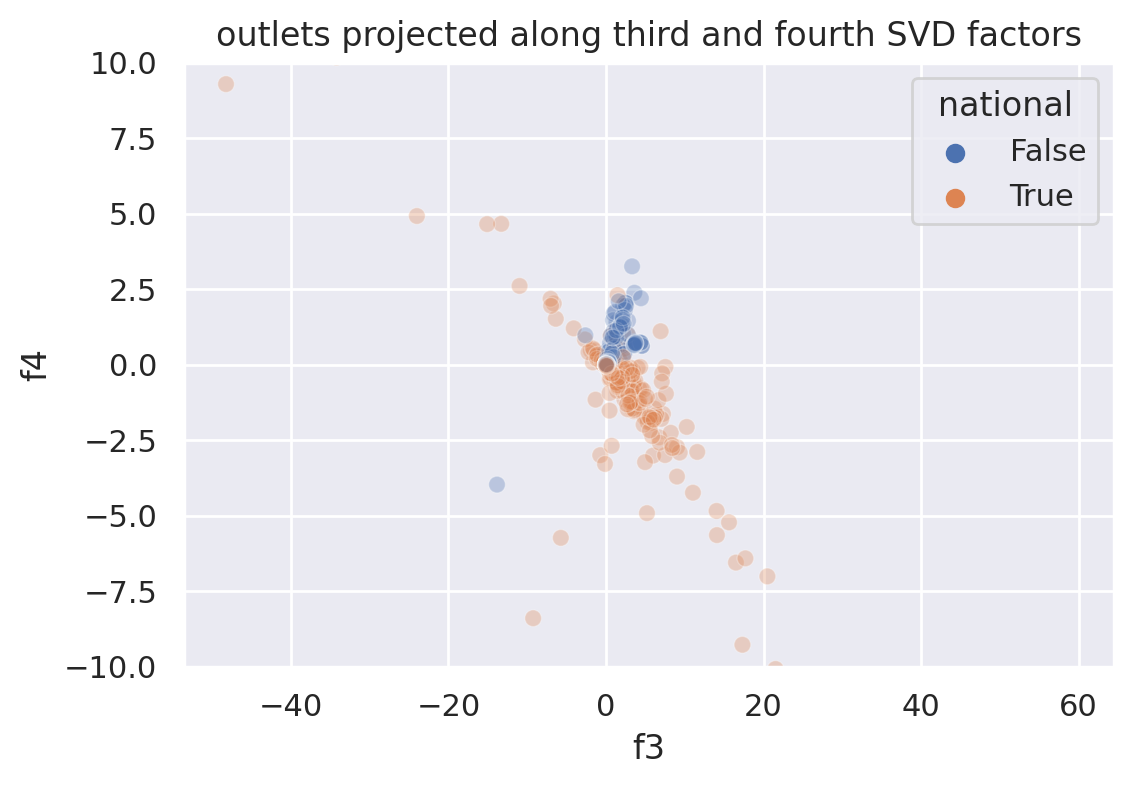

In [303]:
#d2 could mean something like local / national 
sns.scatterplot(x="f3", y="f4", hue="national", data=projDf, alpha=.3)
plt.ylim(-10, 10)
plt.title("outlets projected along third and fourth SVD factors")

In [304]:
import plotly.express as px
import plotly.offline as ofl
plotly.offline.init_notebook_mode(connected=True)
fig = px.scatter(projDf, x="f3", y="f4", hover_data="source")
fig.write_html(INTER_PATH + "f3_f4.html")

Text(0.5, 1.0, 'outlets projected along first two SVD factors')

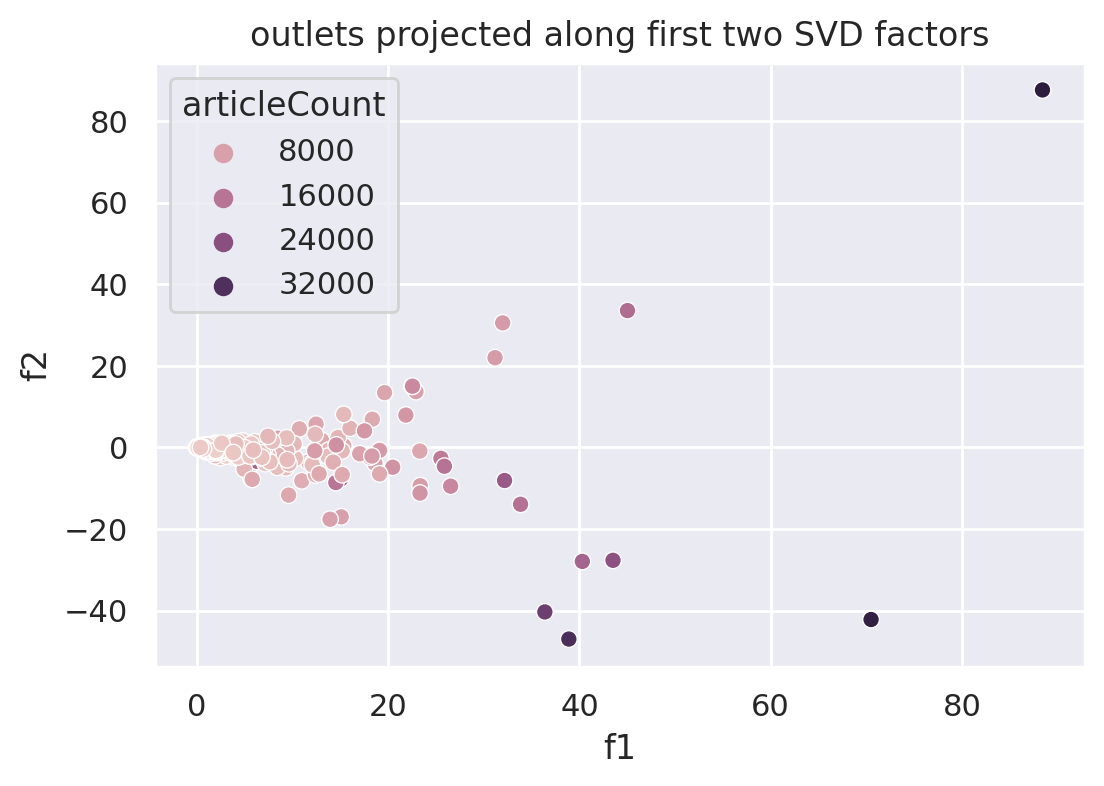

In [305]:
projDf["countBins"] = pd.qcut(projDf["articleCount"], 5) 
colorList = ['#addd8e','#78c679','#41ab5d','#238443','#005a32']
sizePlot = sns.scatterplot(x="f1", y="f2", hue="articleCount",data=projDf, alpha=1)
plt.title("outlets projected along first two SVD factors")

Text(0.5, 1.0, 'outlets projected along the third and fourth SVD factors')

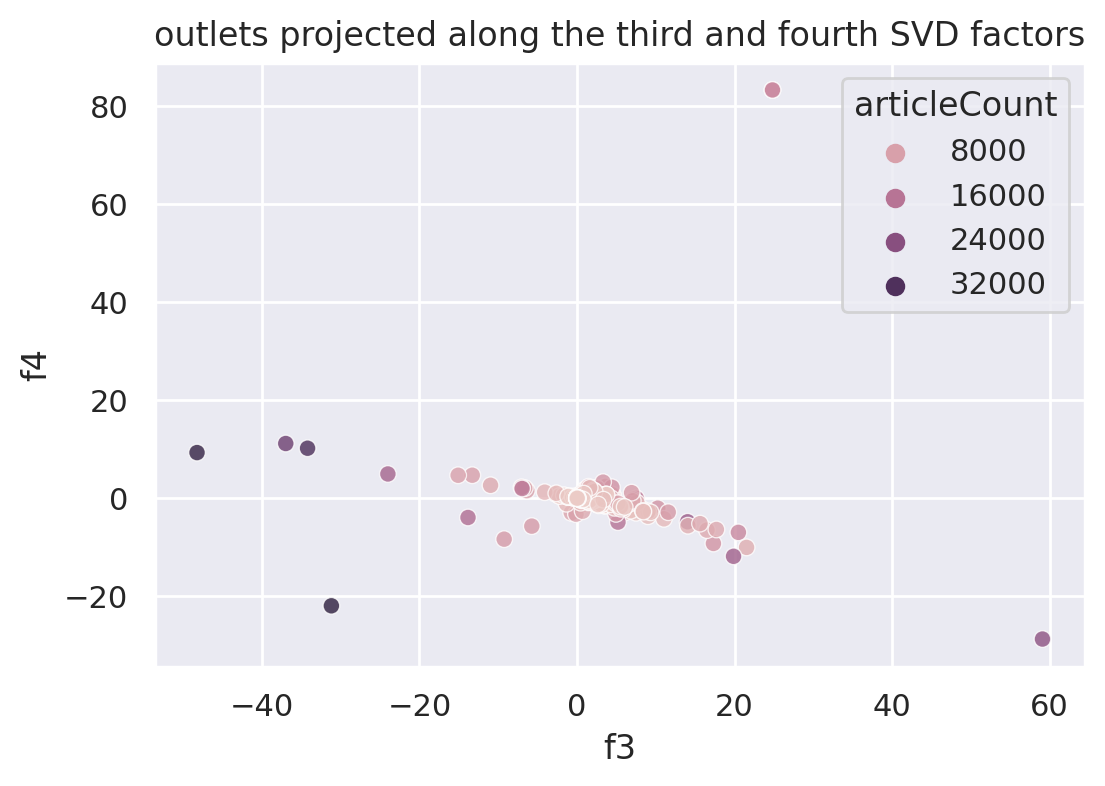

In [306]:
projDf["countBins"] = pd.qcut(projDf["articleCount"], 5) 
colorList = ['#addd8e','#78c679','#41ab5d','#238443','#005a32']
sizePlot = sns.scatterplot(x="f3", y="f4", hue="articleCount",data=projDf, alpha=.8)
plt.title("outlets projected along the third and fourth SVD factors")
#plt.xlim(-20, 20)
#plt.ylim(-20, 20)

Text(0.5, 1.0, 'Outlets projected along third and fourth SVD factors')

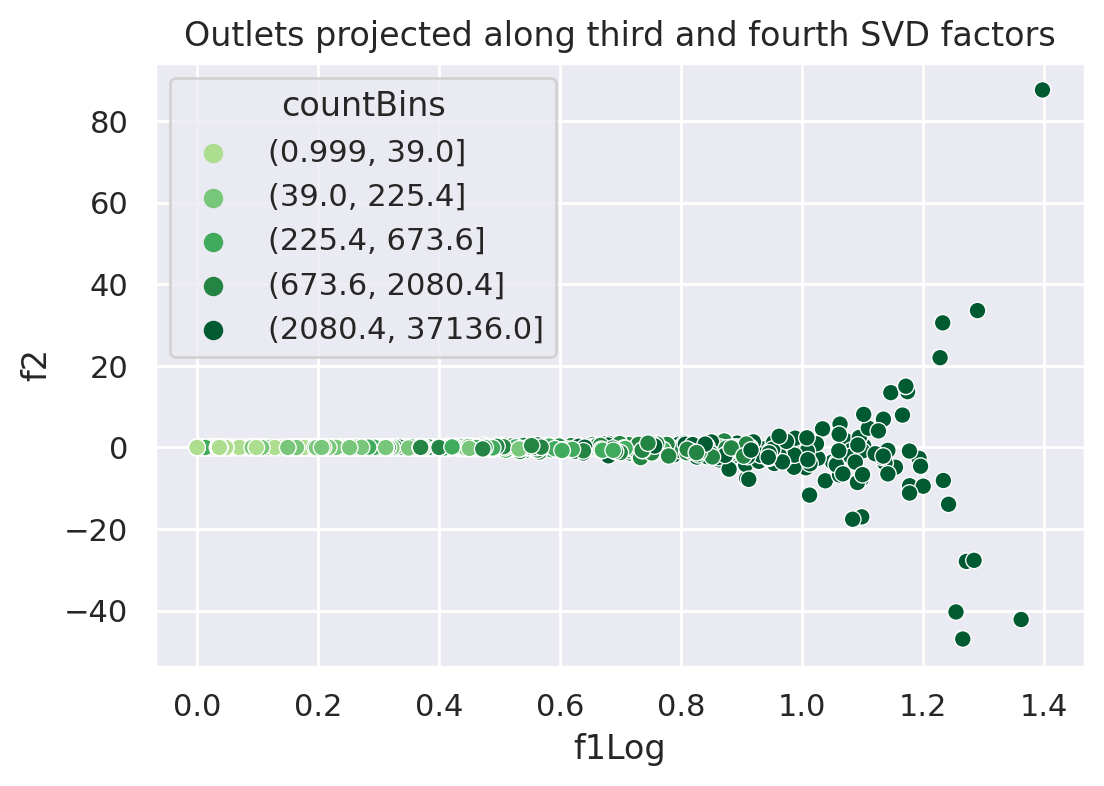

In [307]:

projDf["f1Log"] = (projDf["f1"] + 1).apply(np.log10).apply(np.sqrt)
sizePlot = sns.scatterplot(x="f1Log", y="f2", hue="countBins", palette=colorList,data=projDf, alpha=1)
plt.title("Outlets projected along third and fourth SVD factors")

(-10.0, 10.0)

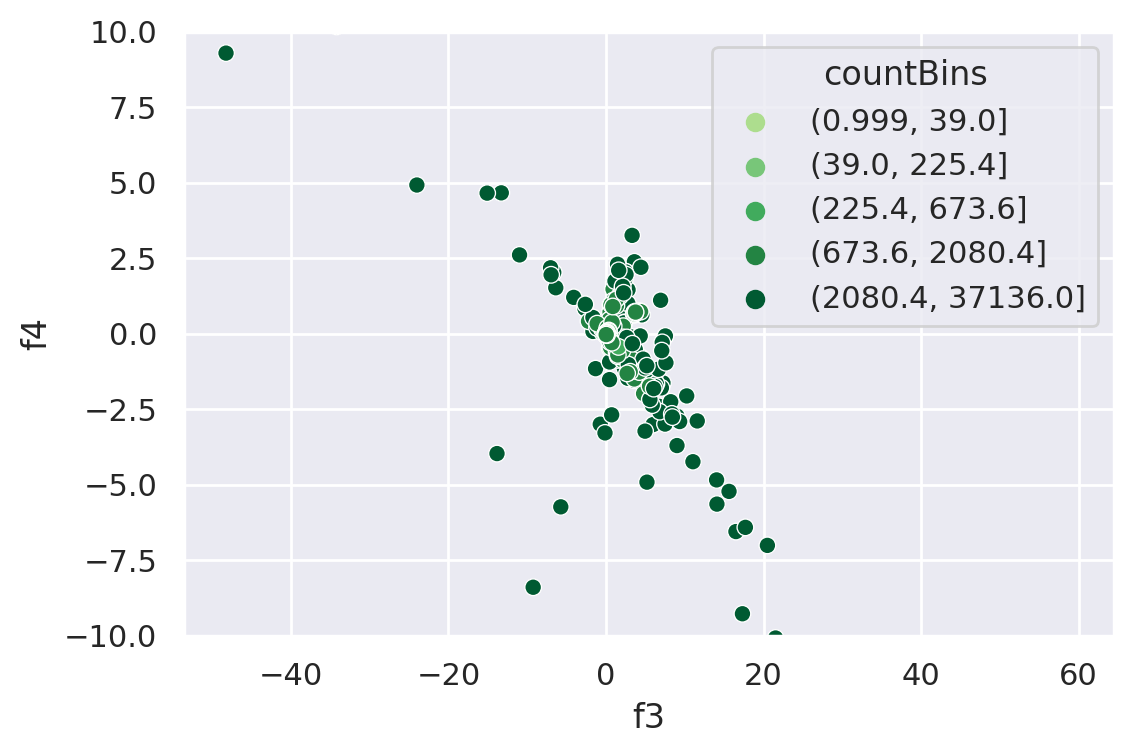

In [308]:

projDf["f3Log"] = (projDf["f3"]).apply(np.sqrt)
projDf["f4Log"] = (projDf["f4"]).apply(np.sqrt)
sizePlot = sns.scatterplot(x="f3", y="f4", hue="countBins", palette=colorList,data=projDf, alpha=1)
plt.ylim(-10, 10)

(0.0, 5.0)

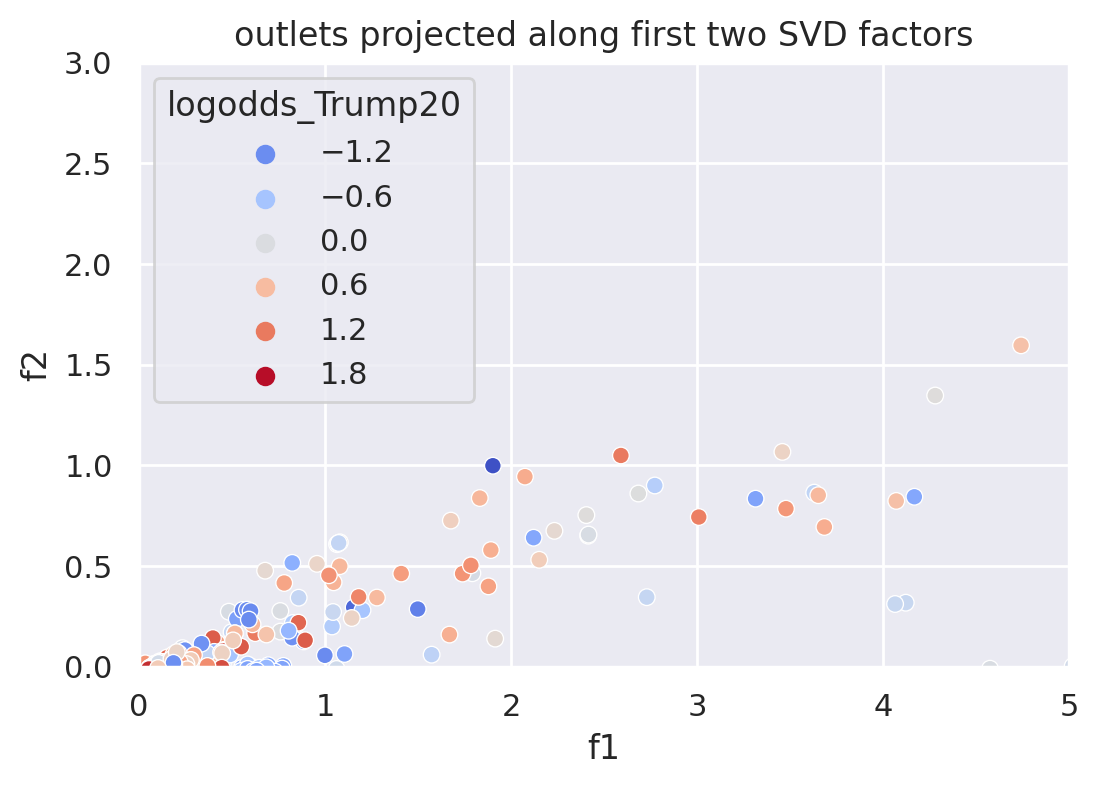

In [309]:
projLocal = projDf[projDf["national"] == False]

sizePlot = sns.scatterplot(x="f1", y="f2", hue="logodds_Trump20", palette="coolwarm", data=projDf, alpha=1)
plt.title("outlets projected along first two SVD factors")
plt.ylim(0, 3)
plt.xlim(0, 5)

(-5.0, 17.88236021443264)

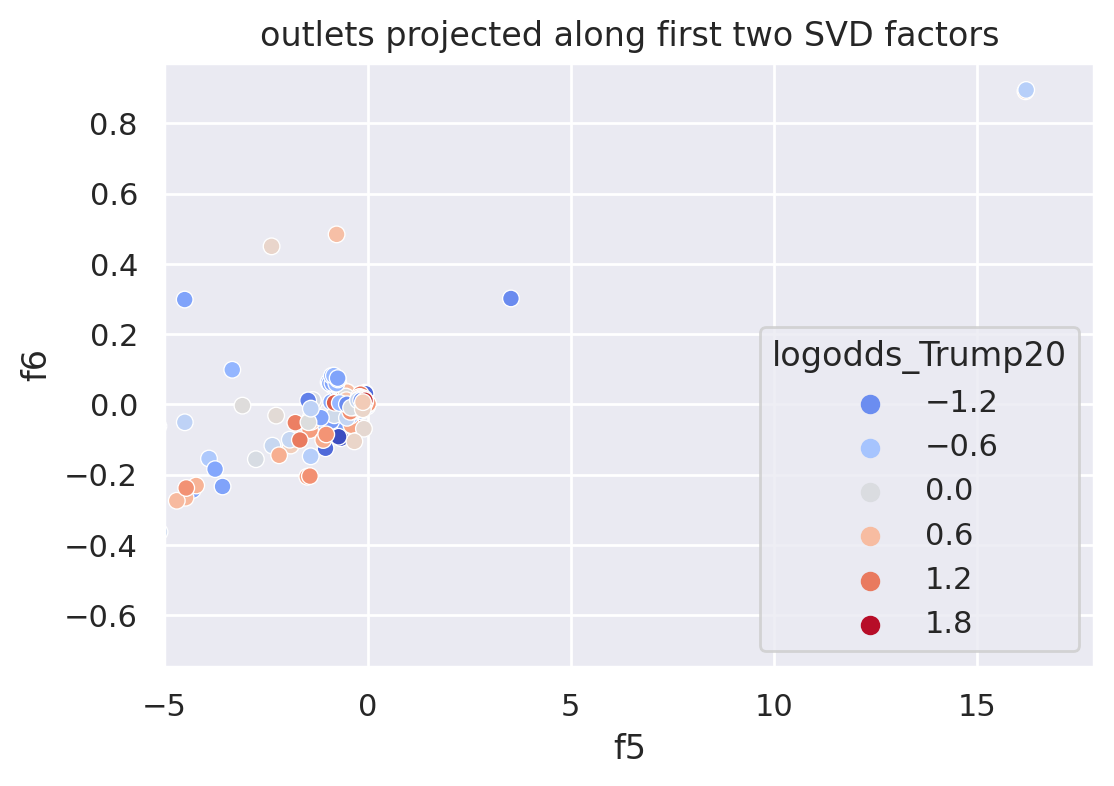

In [310]:
sizePlot = sns.scatterplot(x="f5", y="f6", hue="logodds_Trump20", palette="coolwarm", data=projDf, alpha=1)
plt.title("outlets projected along first two SVD factors")
plt.xlim(-5, )

In [312]:
plotly.offline.init_notebook_mode(connected=True)
fig = px.scatter(projDf, x="f5", y="f6", color="logodds_Trump20", hover_data="source")
fig.write_html(INTER_PATH + "f5_f6_Trump.html")

In [313]:
projLocal.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'source', 'fips', 'logodds_Trump20',
       'logodds_Trump16', 'logodds_Romney12', 'total_population', 'national',
       'white_pct', 'black_pct', 'hispanic_pct', 'nonwhite_pct',
       'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'state', 'articleCount', 'search result',
       'cleanedOwner', 'countBins', 'f1Log', 'f3Log', 'f4Log'],
      dtype='object')

In [49]:
topOwners = pd.DataFrame(projLocal["cleanedOwner"].value_counts())
multOwners = list(topOwners[topOwners["count"] > 3].index)
multOwners

['Gannett',
 'Boone Newspapers',
 'Forum Communications',
 'Digital First Media',
 'Sound Publishing',
 'AIM Media',
 'Morris Multimedia',
 'Black Press Group',
 'Champion Media']

In [50]:
def getOwner(owner):
    if owner in multOwners: 
        return owner
    else: 
        return "None"
    
projLocal["multOwnership"] =projLocal["cleanedOwner"].apply(getOwner)

<ipython-input-50-2124e873a8e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  projLocal["multOwnership"] =projLocal["cleanedOwner"].apply(getOwner)


In [316]:
projLocal["multOwnership"]

6                  None
8                  None
11                 None
12                 None
13     Boone Newspapers
             ...       
772           AIM Media
775                None
776                None
777                None
784                None
Name: multOwnership, Length: 313, dtype: object

In [45]:
palette = ['grey', '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']

(0.0, 0.6)

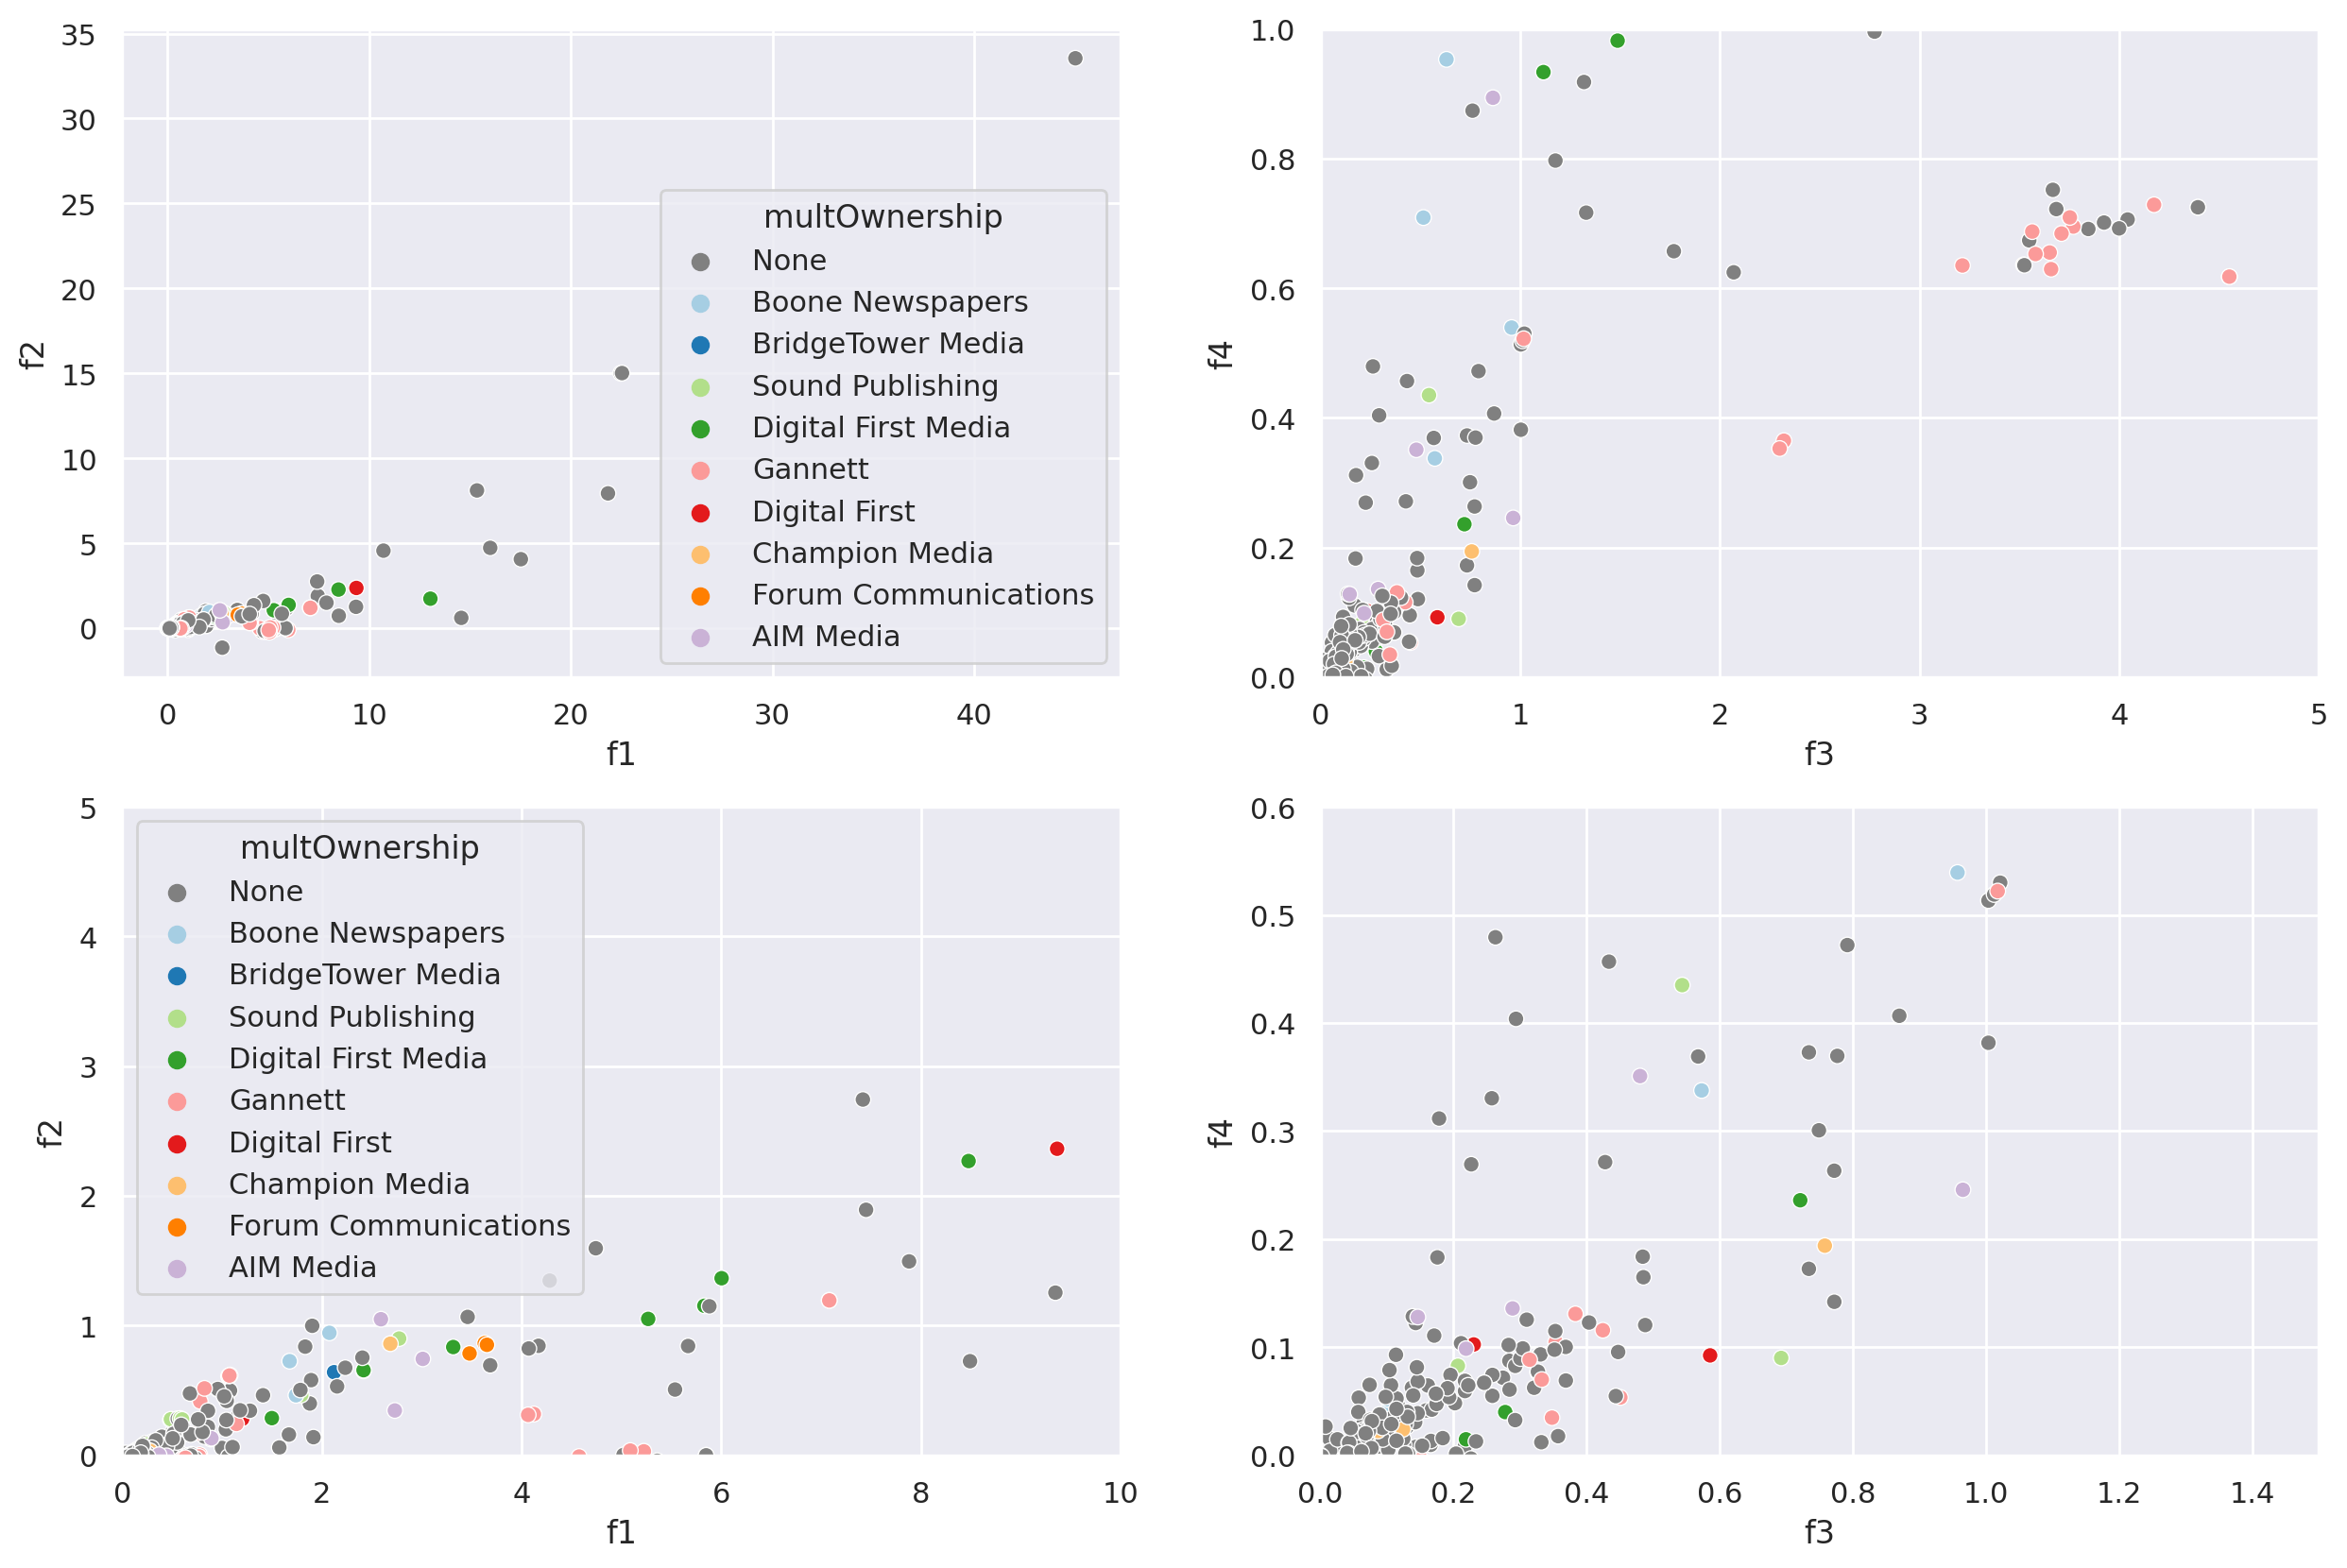

In [318]:
#look into ownership and first few factors 
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(x="f1", y="f2", hue="multOwnership", palette=palette, data=projLocal, alpha=1, ax=axs[0,0])
sns.scatterplot(x="f1", y="f2", hue="multOwnership", palette=palette, data=projLocal, alpha=1, ax=axs[1,0])
axs[1, 0].set_xlim(0, 10)
axs[1, 0].set_ylim(0, 5)
sns.scatterplot(x="f3", y="f4", hue="multOwnership", palette=palette, data=projLocal, alpha=1, ax=axs[0,1], legend=False)
axs[0, 1].set_xlim(0, 5)
axs[0, 1].set_ylim(0, 1)
sns.scatterplot(x="f3", y="f4", hue="multOwnership", palette=palette, data=projLocal, alpha=1, ax=axs[1,1], legend=False)
axs[1, 1].set_xlim(0, 1.5)
axs[1, 1].set_ylim(0, .6)

In [322]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})

In [336]:
len(projLocal)
projLocal["jittered"] = np.random.uniform(-.5, .5, len(projLocal))

<ipython-input-336-6464bc9305fd>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
projLocal[""]

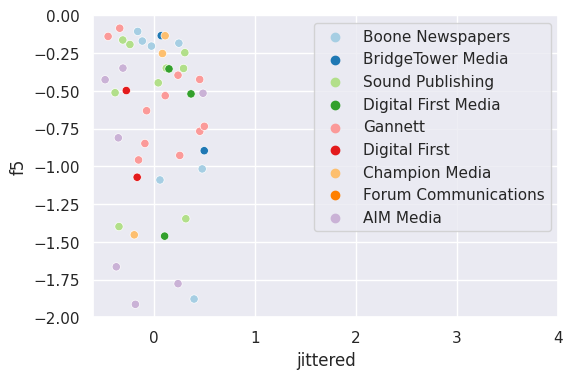

In [343]:
#look into ownership and first few factors 
#fig, axs = plt.subplots(2, 2, figsize=(15, 10))
#ded6d5
palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
sns.scatterplot(x="jittered", y="f5", hue="multOwnership", palette=palette, data=projLocal[projLocal["multOwnership"] != "None"], alpha=1)
plt.xlim(-.6, 4)
plt.ylim(-2, 0)
plt.legend(loc="upper right")
#sns.scatterplot(x="f5", y="f6", hue="multOwnership", palette=palette, data=projLocal, alpha=1, ax=axs[1,0])


In [28]:
#perplexity of 10 was pretty interesting, random state at 13
tsne = TSNE(n_components=2, perplexity=20, random_state=13)
projection = tsne.fit_transform(W)

In [29]:
projDf = pd.DataFrame(projection, columns=["d1", "d2"])
projDf["source"] = sortedOutlets

projDf = pd.merge(projDf, demographicsDf, on="source", how="left")

In [265]:
#get number of stories reported 
storyCounts = merged[["source", "clustNum"]].groupby("source").agg(len).rename(columns={"clustNum":"articleCount"})
projDf = pd.merge(projDf, storyCounts, on="source", how="left")

In [30]:
#merge ownership into our projection dataframe 
ownershipDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/ownership/infoboxUNCOwnership.csv").rename(columns={"ogName":"source"})
projDf = pd.merge(projDf, ownershipDf[["source", "search result", "cleanedOwner"]], on="source", how="left")

In [32]:
ownershipDf.head(3)

,Unnamed: 0,source,pName,search result,WikiOwner,UNCOwner,mergedOwner,cleanedOwner
0,0,andalusiastarnews,andalusia star news,Andalusia Star News,Boone Newspapers,Boone Newspapers,Boone Newspapers,Boone Newspapers
1,1,atmoreadvance,atmore advance,Atmore Advance,Morris Newspaper Corporation/Boone Newspapers ...,Boone Newspapers,Morris Newspaper Corporation/Boone Newspapers ...,Boone Newspapers
2,4,gadsdenmessenger,gadsden messenger,NaN,NaN,"McCharthy, Chris","McCharthy, Chris","McCharthy, Chris"


NameError: name 'plt' is not defined

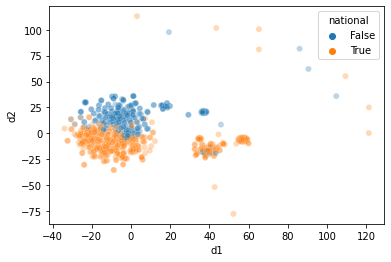

In [33]:
sns.scatterplot(x="d1", y="d2", hue="national", data=projDf, alpha=.3)
plt.title("T-SNE: Local vs. National")

In [243]:
fig = px.scatter(projDf, x="d1", y="d2", color="national", hover_data="source")
fig.write_html(INTER_PATH + "TSNE_local_nat.html")

Text(0.5, 1.0, 'T-SNE: number of articles reported')

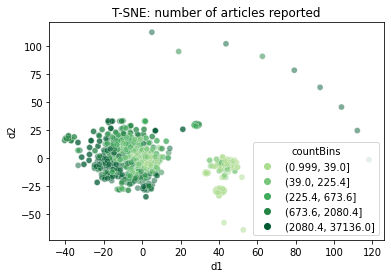

In [244]:
projDf["countBins"] = pd.qcut(projDf["articleCount"], 5) 
colorList = ['#addd8e','#78c679','#41ab5d','#238443','#005a32']
sizePlot = sns.scatterplot(x="d1", y="d2", hue="countBins", palette=colorList, data=projDf, alpha=.5)
plt.title("T-SNE: number of articles reported")

In [126]:
projDf["countBins"] = pd.qcut(projDf["articleCount"], 5) 
colorList = ['#addd8e','#78c679','#41ab5d','#238443','#005a32']
sizePlot = sns.scatterplot(x="d1", y="d2", hue="countBins", palette=colorList, data=projDf, alpha=.5)
plt.title("T-SNE: number of articles reported")

,f1,f2,f3,f4,f5,f6,source,fips,logodds_Trump20,logodds_Trump16,...,lesscollege_pct,lesshs_whites_pct,lesscollege_whites_pct,rural_pct,ruralurban_cc,articleCount,countBins,f1Log,f3Log,f4Log
6,0.067444,0.007798,0.038564,0.006635,-0.060260,0.010323,addisoncountyindependent,50001.0,-0.866569,-0.750468,...,64.225999,7.231319,64.337960,78.430787,6.0,59,"(39.0, 225.4]",0.168360,0.196378,0.081456
8,0.120180,0.009291,0.057478,0.053167,-0.155218,0.009548,advertiserdemocrat,23017.0,0.183960,0.286490,...,81.849266,8.508187,81.929601,83.111718,6.0,254,"(225.4, 673.6]",0.222009,0.239746,0.230580
11,1.153982,0.293835,0.487822,0.120380,-1.034632,-0.124540,alamedatimesstar,6001.0,-1.511436,-1.680325,...,56.112170,3.985874,44.988839,0.388606,1.0,1217,"(673.6, 2080.4]",0.577271,0.698442,0.346958
12,0.298548,0.102278,0.078733,-0.031954,-0.182289,0.031585,alaskajournalofcommerce,2020.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,122,"(39.0, 225.4]",0.336835,0.280593,NaN
13,1.676569,0.724746,0.572587,0.337480,-1.879225,-0.112378,albertleatribune,27047.0,0.329543,0.377091,...,83.244948,8.568259,81.890161,42.831547,7.0,1375,"(673.6, 2080.4]",0.653895,0.756695,0.580930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,2.590961,1.048142,0.863620,0.893683,-1.665969,-0.101005,wilmingtonnewsjournal,39027.0,1.195664,1.224759,...,83.508089,11.194760,83.467590,54.638440,6.0,1511,"(673.6, 2080.4]",0.745125,0.929312,0.945348
775,0.203239,0.071362,0.076551,0.006542,-0.117356,-0.013615,winstoncountyjournal,28159.0,0.235346,0.243201,...,82.740997,14.285714,74.528571,75.914158,7.0,278,"(225.4, 673.6]",0.283464,0.276679,0.080882
776,0.185333,0.018410,0.127554,0.001453,-0.158297,0.011480,wisconsinnewspaperassociation,55025.0,-1.194480,-1.115717,...,50.973844,2.721792,49.319465,12.329918,2.0,90,"(39.0, 225.4]",0.271736,0.357146,0.038115
777,0.053181,-0.012142,0.040130,0.002016,-0.063630,0.011982,wisecountymessenger,48497.0,1.695325,1.801385,...,83.092524,10.160491,81.647742,72.107497,1.0,100,"(39.0, 225.4]",0.150010,0.200326,0.044895


In [51]:
#now add ownership info and see if we get anything interesting 
projLocal = projDf[projDf["national"] == False]

In [52]:
projLocal["multOwnership"] = projLocal["cleanedOwner"].apply(getOwner)

<ipython-input-52-57b01b60cbb1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  projLocal["multOwnership"] = projLocal["cleanedOwner"].apply(getOwner)


In [53]:
import matplotlib.pyplot as plt

In [54]:
plt.rcParams['figure.dpi'] = 500
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})

In [56]:
palette = ['grey', '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']

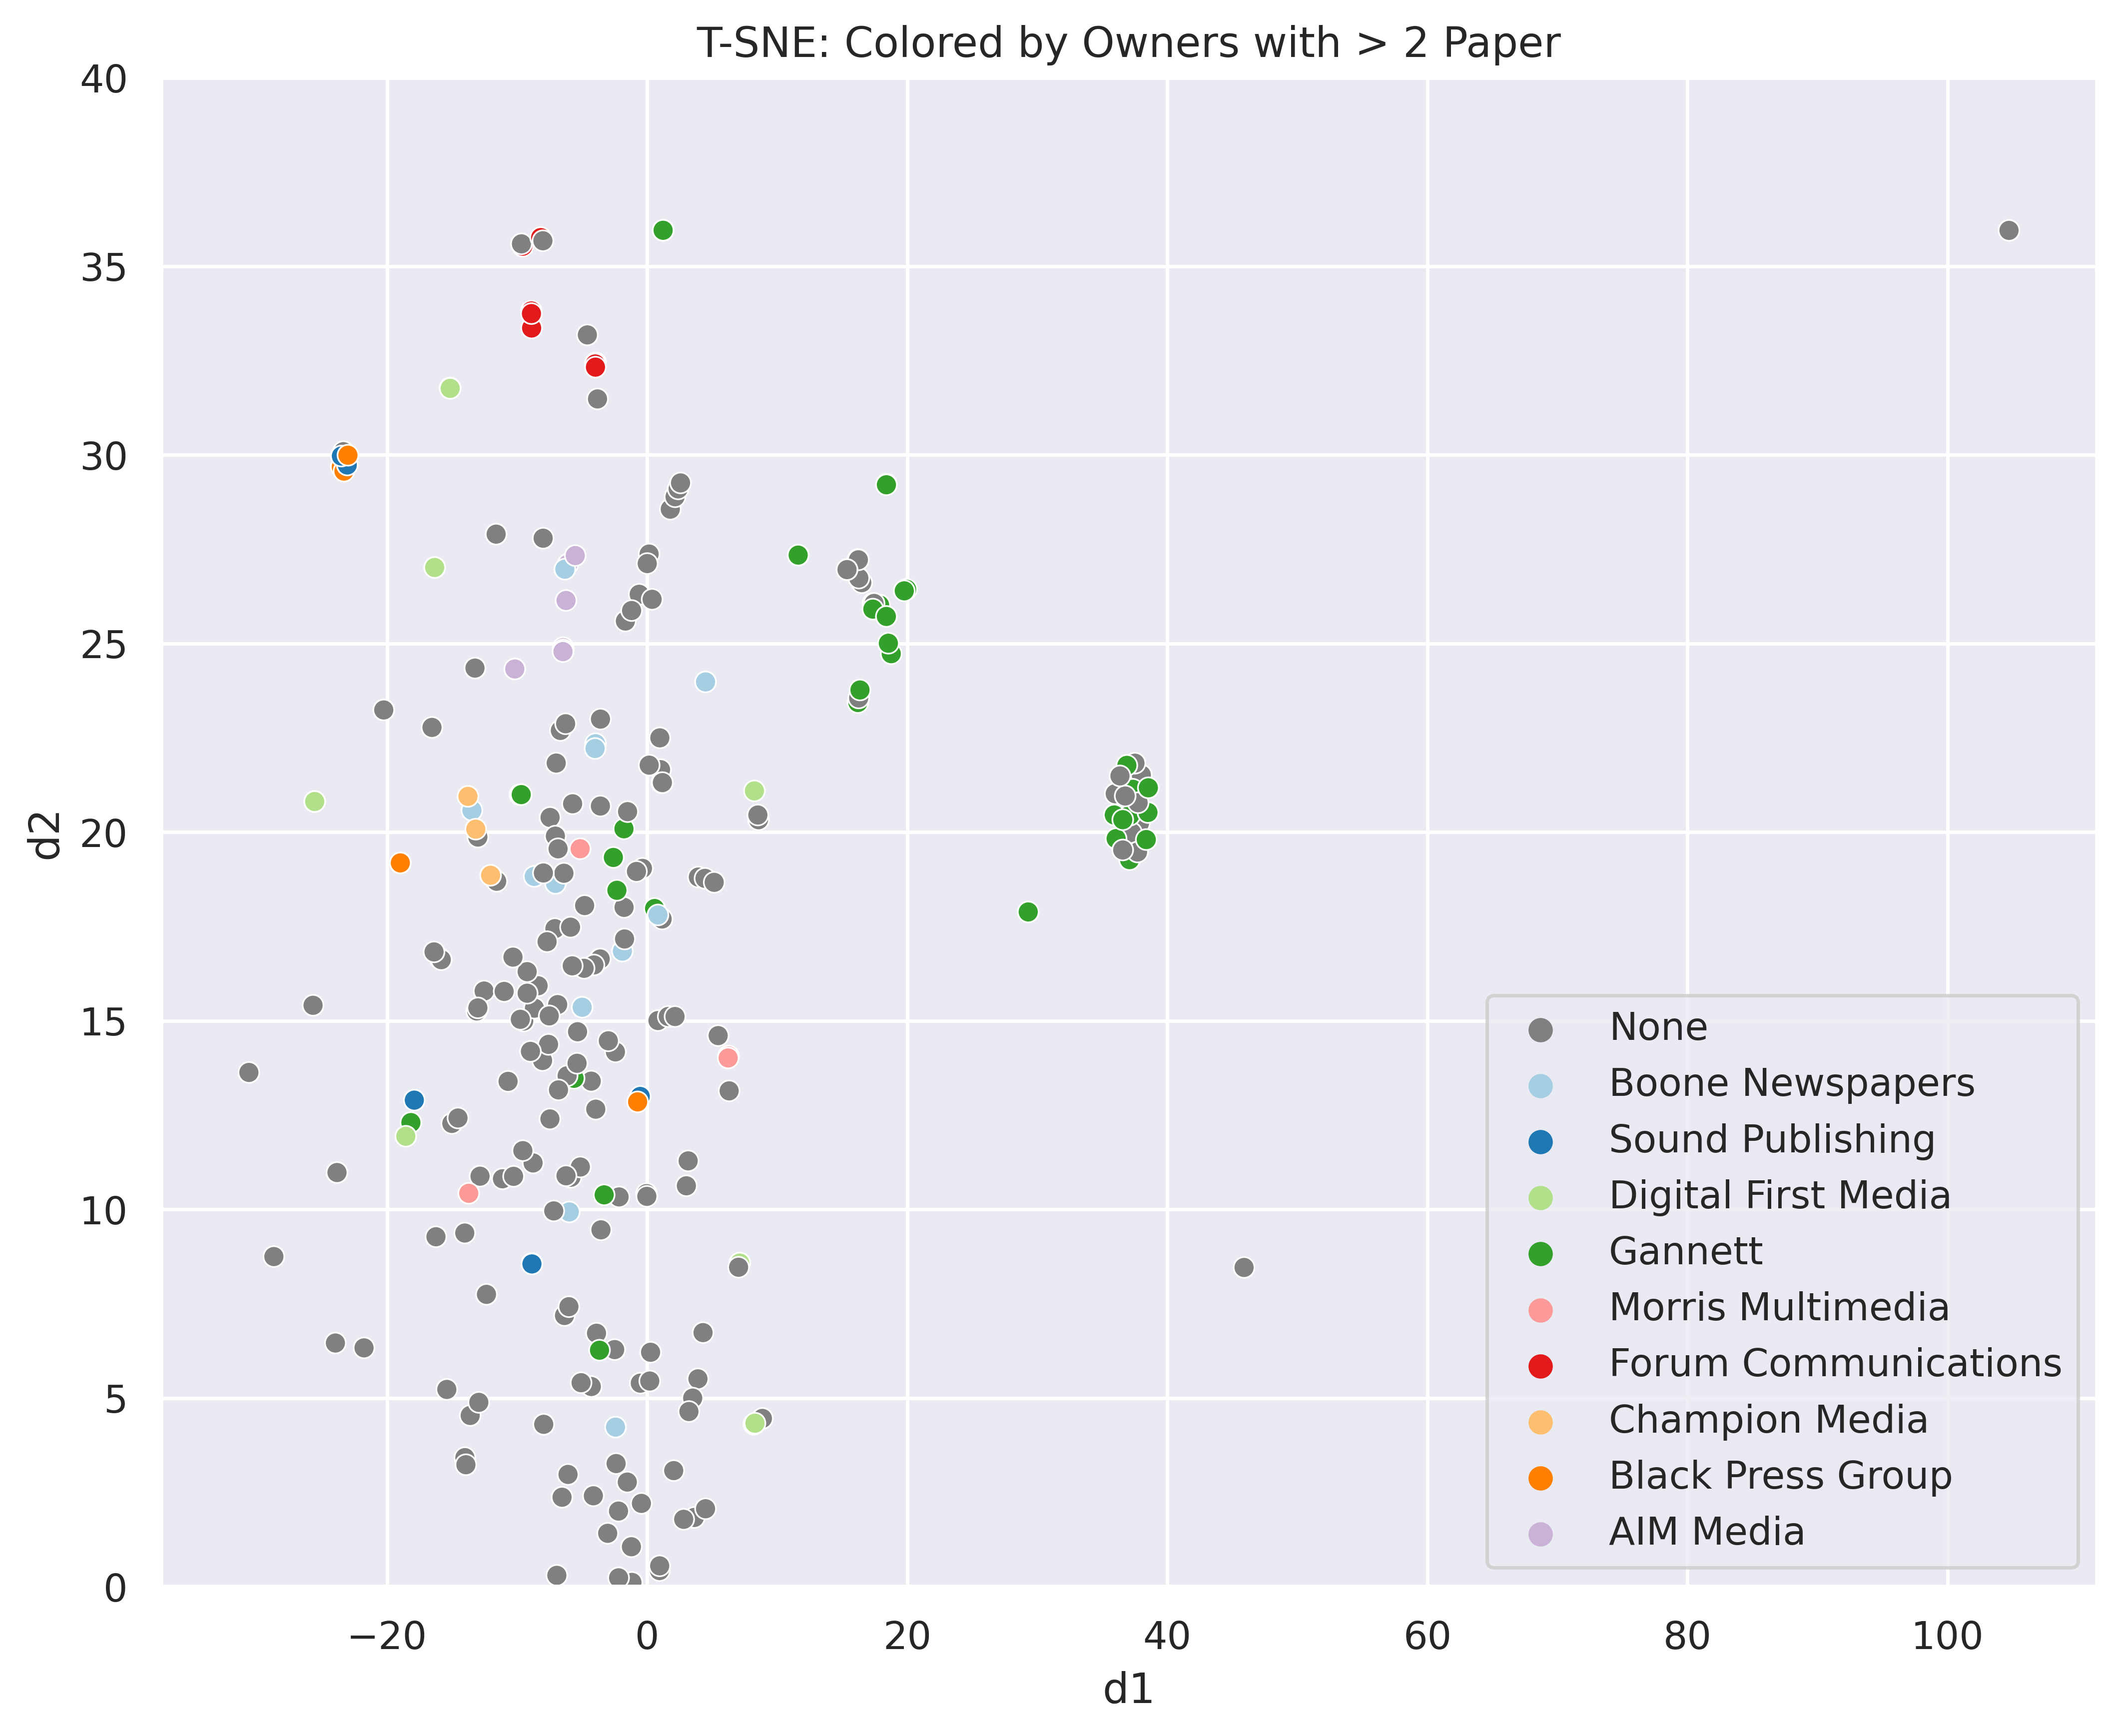

In [57]:
fig, axs = plt.subplots(figsize=(10, 8))
sizePlot = sns.scatterplot(x="d1", y="d2", hue="multOwnership",palette=palette, data=projLocal, alpha=1)
plt.title("T-SNE: Colored by Owners with > 2 Paper")
plt.ylim(0, 40)
plt.legend(loc="lower right")
plt.show()
fig.savefig("plotly/TSNE_local_ownership_sns.jpg")

In [270]:
fig = px.scatter(projLocal, x="d1", y="d2", color="multOwnership", hover_data="state")
fig.write_html(INTER_PATH + "TSNE_local_ownership.html")